In [1]:
import numpy as np
from numpy import linalg as LA
import scipy
import scipy.stats as stats
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import sqrtm

In [2]:
n = 40
m = 190
r = 1
r_star = 1
sigma=0.05
tau = 0.25

In [3]:
def rand_H(m,n):
    A = stats.multivariate_normal.rvs(cov=0.005,size=(m,n**2))
    for i in range(m):
        sensing = np.reshape(A[i,:],(n,n))
        sensing = 0.5*(sensing+sensing.T)
        A[i,:] = np.reshape(sensing,n**2)
    H = A.T @A
    return (A,H)

In [4]:
def RIP_const(H,sim_num,n,r):
    ratios = np.zeros(sim_num)
    for i in range(sim_num):
        Z_t = stats.multivariate_normal.rvs(size=(n,2*r))
        M_t = Z_t@Z_t.T

        e_t = np.reshape(M_t.T,n*n)
        ratios[i] = (e_t.T@H@e_t)/(LA.norm(e_t)**2)

    return np.maximum(np.abs(1-np.min(ratios)),np.abs(1-np.max(ratios)))

In [16]:
H = np.load('H_rip_0_42.npy')
A = np.load('A_rip_0_42.npy')

In [27]:
#generates a random H without RIP consideration
(A,H) = rand_H(m,n)

print(RIP_const(H,1000,n,r))

0.3794989886946849


In [ ]:
#generate H that complies with RIP

ripconst = 1
while (ripconst > 0.5):
    (A,H) = rand_H(m,n)
    ripconst = RIP_const(H,500,n,r)

In [45]:
#random gaussian generation of Z
Z_rr = stats.multivariate_normal.rvs(size=(n,r_star))
if r_star==1:
    temp = np.zeros((n,r))
    temp[:,0:r_star] = np.expand_dims(Z_rr,axis=1)
    Z_rr = temp
else:
    u, s, vh = np.linalg.svd(Z_rr)
    if len(s) > r_star:
        s[r_star-1:] = np.zeros(len(s)-r_star)
    Z_rr = (u[:,:r_star]*s) @ vh
    Z_rr = np.concatenate((Z_rr,np.zeros((n,r-r_star))),axis=1)

M_star_rr = Z_rr @ Z_rr.T
print(np.linalg.matrix_rank(M_star_rr))

1


In [56]:
#diagonal Z (differ from the above random generation)
M_star_rr = np.zeros(n)
M_star_rr[0:r_star] = np.linspace(1,1.5,r_star)
M_star_rr = np.diag(M_star_rr)
Z_rr = np.eye(n)[:,0:r]@np.sqrt(M_star_rr[0:r,0:r])

In [57]:
#perturbed ground truth(and the associated noise)
Z_rr_w = Z_rr+np.random.randn(n,r_star)*0.1
M_w = Z_rr_w@Z_rr_w.T

w = A@np.reshape(M_w.T,n*n)-A@np.reshape(M_star_rr.T,n*n)

In [52]:
#random generation of noise
w = stats.multivariate_normal.rvs(cov=sigma**2*np.eye(m))

In [58]:

_, sig_values, _ = np.linalg.svd(A)
sig_min_A = np.min(sig_values)
sig_max_A = np.max(sig_values)
A = A/(sig_max_A)*2
_, sig_values, _ = np.linalg.svd(A)
sig_min_A = np.min(sig_values)
sig_max_A = np.max(sig_values)
_, sig_values, _ = np.linalg.svd(M_star_rr)
lambda_r_star_Mstar = np.min(sig_values[0:r_star])
lambda_1_Mstar = np.max(sig_values[0:r_star])

In [ ]:
#for verification
print(RIP_const(H,200000,n,r))

In [9]:
np.save('H_rip_0_42.npy',H)
np.save('A_rip_0_42.npy',A)

This section wants to demonstrate the linear convergence of vanilla GD methods when initalized close enough with small enough stepsize.

In [42]:
def X_bold(X):
    #takes a n-by-r matrix X and return the bold X of dim n^2-by-nr s.t. bold_X vec(U) = vec(XU^T + UX^T)
    bold_X = np.zeros((n**2,n*r))
    for i in range(n*r):
            U = np.zeros((n,r))
            y_i = int(np.floor(i/n))
            x_i = int(i % n)
            U[x_i,y_i] = 1
            bold_X[:,i] = np.reshape((X @ U.T + U @ X.T).T,n*n)
    
    return bold_X

In [59]:
X = stats.multivariate_normal.rvs(size=(n,r))*5
X = X.reshape((n,r)) # in case r=1
eta = 0.001

iter_max = 20000
e_norms = np.zeros(iter_max)
for iter in range(iter_max):
    e = np.reshape((X @ X.T - M_w).T,n*n)
    e_norms[iter] = LA.norm(e)
    bold_X = X_bold(X)
    grad = bold_X.T@A.T@(A@e+w)
    grad = np.reshape(grad,(r,n)).T
    X = X - eta*grad

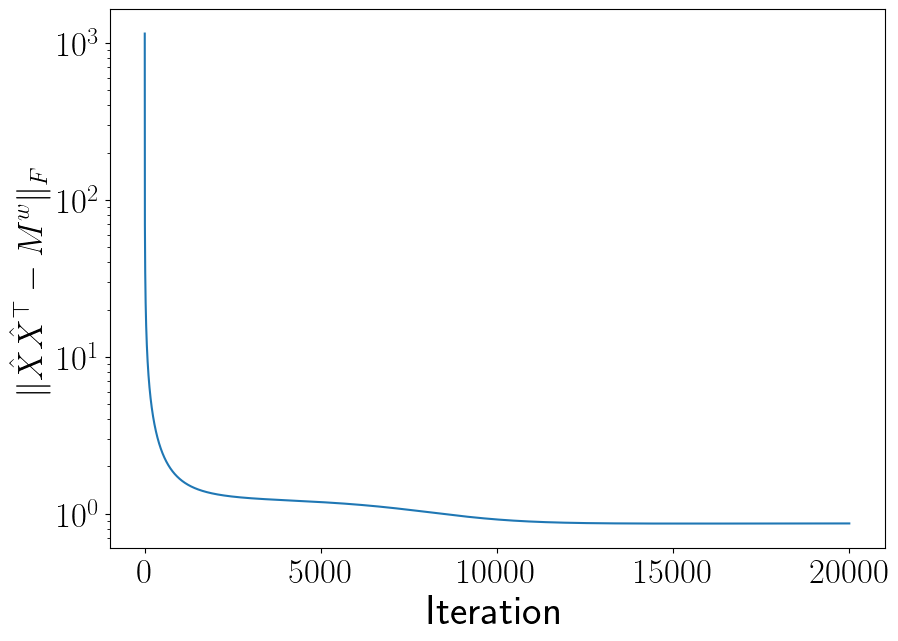

0.8659281635178435


In [60]:
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rcParams['figure.figsize'] = [10, 7]
plt.plot(np.arange(iter_max),e_norms)
plt.yscale('log')
plt.xlabel('Iteration',size=30)
plt.ylabel('$\|\hat X \hat X^\\top-M^w\|_F$',size=25)
# plt.title('$\|XX^\\top-M^*\|_F$ bound, from first inequality',size=20)
# plt.savefig('/Users/gavenma/Documents/GitHub/RIP_project/journal_ext/figures/global_ineq1_rstar.png')
plt.show()

print(np.min(e_norms))

Want to calculate the $\delta$ needed for a certain distance upperbound for the local Theorem

In [78]:
zeta_1 = sig_max_A
zeta_2 = 0

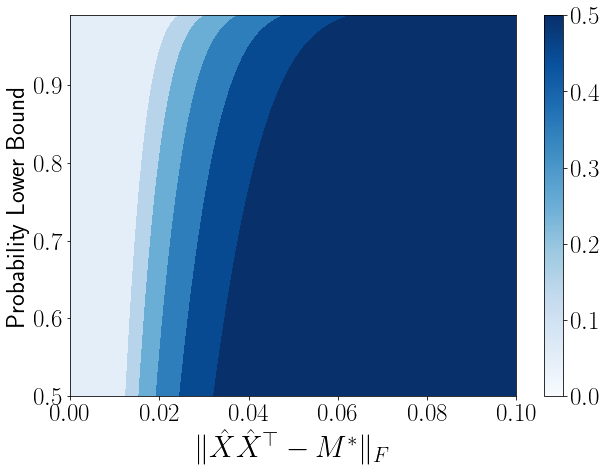

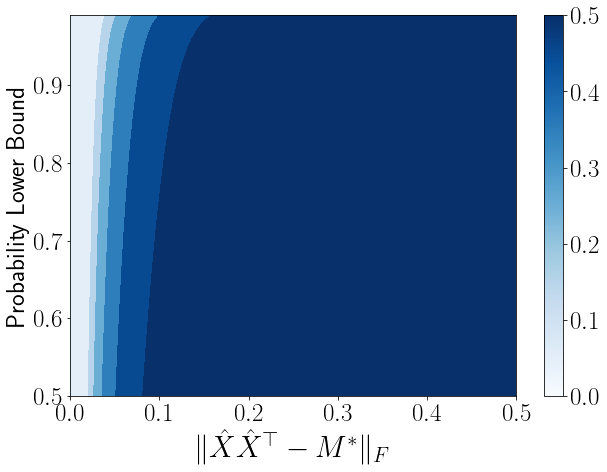

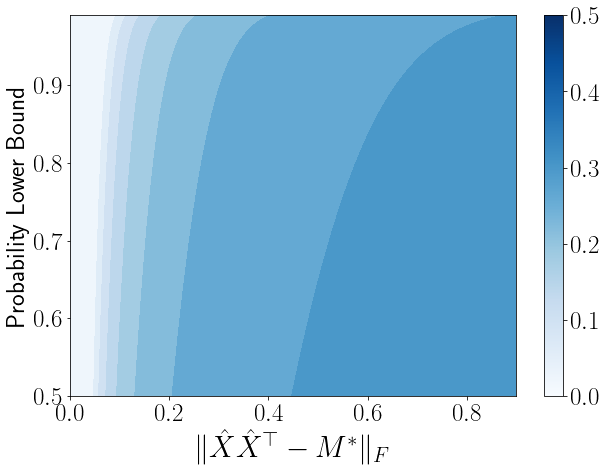

In [92]:
probs = np.linspace(0.5,0.99,200)


for tau in [0.1,0.5,0.9]:
    r_star = r
    distances = np.linspace(0.0,tau*lambda_r_star_Mstar,200)
    xx,yy = np.meshgrid(distances,probs)

    epsilons_rr = np.sqrt(-np.log((-yy+1)/2)*16*sigma**2*m)

    C = np.sqrt(2*(lambda_1_Mstar+tau*lambda_r_star_Mstar))

    delta_ub_local = (xx*(np.sqrt(1-tau)-zeta_2*epsilons_rr)-epsilons_rr*(1+zeta_2*epsilons_rr)*zeta_1*C)/(xx+zeta_1*epsilons_rr*C)

    delta_ub_local = np.maximum(delta_ub_local,0)

    plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=25)
    plt.rc('ytick',labelsize=25)
    plt.rcParams['figure.figsize'] = [10, 7]
    fig, ax = plt.subplots()
    qcs = ax.contourf(distances, probs, np.maximum(delta_ub_local,0), cmap=plt.cm.Blues,vmin=0, vmax=0.5)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))
    # plt.contourf(distances,probs,np.maximum(delta_ub_local_2,0),cmap=plt.cm.summer)
    # plt.colorbar()
    plt.xlim(left=0)
    plt.xlabel(r'$\| \hat X \hat X^\top-M^*\|_F$',size=30)
    plt.ylabel('Probability Lower Bound',size=25)
    # plt.title('Local $\delta$ bound, $\\tau=$'+str(tau),size=20)
    # if tau == 0.82:
    #     plt.title('Local $\delta$ bound, $\\tau=2(\sqrt{2}-1)$',size=20)
    plt.show()

Want to calculate the $\delta$ needed for a certain distance upperbound for the global

/var/folders/5f/3x0grpy12bz8m_q8r1l004fc0000gn/T/ipykernel_30716/4196138763.py:6: RuntimeWarning: divide by zero encountered in true_divide
  delta_ub_global = 1/3 - zeta_2*epsilons_rr - (2/3)*zeta_1*(epsilons_rr/xx)


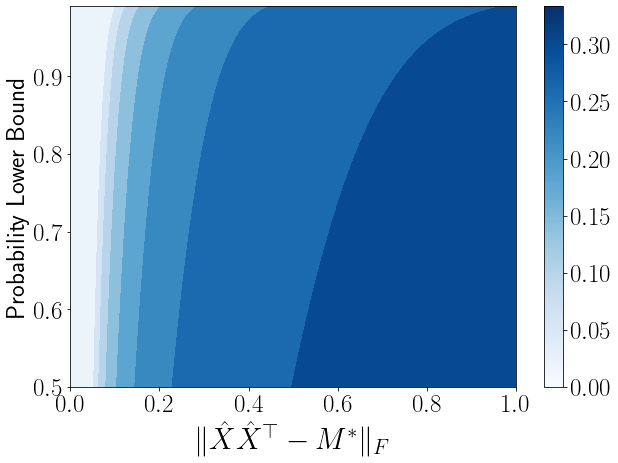

In [95]:
distances = np.linspace(0.0,lambda_r_star_Mstar,200)
xx,yy = np.meshgrid(distances,probs)

epsilons_rr = np.sqrt(-np.log((-yy+1)/2)*16*sigma**2*m)

delta_ub_global = 1/3 - zeta_2*epsilons_rr - (2/3)*zeta_1*(epsilons_rr/xx)

delta_ub_global = np.maximum(delta_ub_local,0)
delta_ub_global = np.minimum(delta_ub_local,1/3)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rcParams['figure.figsize'] = [10, 7]
fig, ax = plt.subplots()
qcs = ax.contourf(distances, probs, np.maximum(delta_ub_global,0), cmap=plt.cm.Blues,vmin=0, vmax=1/3)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=qcs.norm, cmap=qcs.cmap))
# plt.contourf(distances,probs,np.maximum(delta_ub_local_2,0),cmap=plt.cm.summer)
# plt.colorbar()
plt.xlim(left=0)
plt.xlabel(r'$\| \hat X \hat X^\top-M^*\|_F$',size=30)
plt.ylabel('Probability Lower Bound',size=25)
# plt.title('Local $\delta$ bound, $\\tau=$'+str(tau),size=20)
# if tau == 0.82:
#     plt.title('Local $\delta$ bound, $\\tau=2(\sqrt{2}-1)$',size=20)

plt.show()